# 1. Text Cleaning

In [ ]:
import pandas as pd 
import numpy as np
import os
base_dir = "YOUR_PATH/net2020-main"
os.chdir(base_dir)

import matplotlib.pyplot as plt

# import the csv file with all the comments and post togheter
comDB = pd.read_csv(r"database/com_liwc.csv", sep='\t', engine='python')

# import the csv file with JUST the politicians post
postDB = pd.read_csv(r"database/postDB.csv", engine='python')

In [ ]:
# create the Data Frame
df = pd.DataFrame(data=comDB)
df_post = pd.DataFrame(data=postDB)

df

# add a new colum with sequence numbers
df['Count']=1
df_post['Count']=1

# print all the DF
pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', 5)

#df.head()

# Data Analysis

## NaN values

In [ ]:
print('Columns with Nan in df:\n', [(col, df[col].isna().sum()) for col in df.columns if df[col].isna().sum()>0], '\n')
print('Columns with Nan in df_post:\n', [(col, df_post[col].isna().sum()) for col in df_post.columns if df_post[col].isna().sum()>0])

Columns with Nan in df:
 [('p_GRUPPO_PE', 4215), ('p_PARTITO', 1692), ('p_text', 2), ('Target1', 40762), ('Target2', 71745), ('target1_s-p', 40868), ('target1_pol', 40868), ('c_text', 1), ('c_replyToUser', 314), ('c_replyToText', 733), ('Unnamed: 38', 78175)] 

Columns with Nan in df_post:
 [('p_GRUPPO_PE', 420), ('p_PARTITO', 286), ('p_text', 1), ('Target1', 6507), ('Target2', 9538), ('target1_s-p', 6513), ('target1_pol', 6513), ('c_replyToUser', 24), ('c_replyToText', 64), ('Unnamed: 38', 10103), ('target1_2', 9538)]


For the moment we are concerned about the NaN in the columns related to posts and comments text.

### NaN in comments dataframe

In [ ]:
# Identify rows with NaN in post text in df (comments dataframe)
df[df['p_text'].isna()][['Origin_file_order']]

Origin_file_order
39085              25908
45804              84591

In [ ]:
# Identify rows with NaN in comment text in df (comments dataframe)
df[df['c_text'].isna()][['Origin_file_order']]

Origin_file_order
45804              84591

Row 45804 in comments dataframe can be removed since we have neither the text of the post nor the text of the comment associated with it.

In [ ]:
print('df shape before dropping row: \t', df.shape)
df = df[df['c_text'].notna()]
print('df shape after dropping row: \t', df.shape)
print('Number of Nan in comments text: ', df['c_text'].isna().sum())

df shape before dropping row: 	 (78175, 244)
df shape after dropping row: 	 (78174, 244)
Number of Nan in comments text:  0


In [ ]:
df.shape

(78174, 244)

### NaN in posts dataframe

In [ ]:
# Identify rows with NaN in post text in df_post (posts dataframe)
df_post[df_post['p_text'].isna()][['Origin_file_order']]

Origin_file_order
3854              25908

# Comments Text Preprocessing

Let us create a dataframe containing only the comments' text

In [ ]:
# comments = df[['c_text']].sample(n=1000, random_state=1).copy() # work with a sample
comments = df[['c_text']].copy()
comments.rename(columns={'c_text':'text'}, inplace=True)

In [ ]:
import random
for i in list(np.random.choice(list(comments.index), 5)):
    print(f'Comment {i}')
    print(comments.loc[i]['text'], '\n')

Comment 53224
Matteo Lucherini Bargellini lui √® alto. Lei √® bellissima. 

Comment 4566
Filippo Pasquali √® una responsabilit√† che mi onora. Francamente. Senza chiacchiere.
Grazie. 

Comment 19954
@GiorgiaMeloni La castrazione chimica √® solo una perdita di tempo. Abbiamo due, tre vulcani in Italia che potremmo utilizzare per incenerire chi non merita di vivere. 

Comment 45840
Alex Tamburino Ma che cazzo di gente siete con quel cervello dove volete andare!!! 

Comment 25327
Chi ci mettiamo formicano lui era capace svegliatevi cacciamo via i ladri 



## Word cloud with raw data

What if we generate a word cloud with no-preprocessed text?

In [ ]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
% matplotlib inline

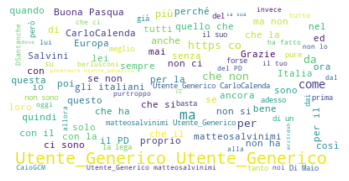

In [ ]:
full_text = " ".join(comm for comm in comments['text'])

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(full_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

The word cloud we get is full of so-called stop words, the only significant words we can recognize are names of parties or politicians. A bit of text pre-processing is therefore mandatory.



## Text pre-processing

There are differnt types of text preprocessing steps which can be applied and the choice of these steps depends on the tasks to be performed.


For this initial step, our goal is to identify the most used words in the comments and the main topics of discussion.

### Removal of patterns

In [ ]:
import re
from collections import Counter

def remove_patterns(text, patterns):

    for pattern in patterns:
        r = re.findall(pattern, text)
        for i in r:
            text = re.sub(re.escape(i), '', text)   
    return text

def pattern_freq(docs, pattern):
    p_freq = Counter()
    for text in docs:
        p_found= re.findall(pattern, text)
        for p in p_found:
            p_freq[p] += 1
    return p_freq

In [ ]:
!pip install emoji
import emoji

In [ ]:
PATTERNS = {'urls': re.compile(r'https?://\S+|www\.\S+'),
            'users': re.compile(r'@[\w]*'),
            #'hashtags': re.compile(r'#[\w]*'),
            'digits': re.compile(r'(?<!\w)\d+|\d+(?!\w)'),
            'emojis': emoji.get_emoji_regexp()
}

Before removing patterns we can answer dollowing questions:
* Which are the most used hashtags?
* Which are most tagged users?
* Are there frequent URLs?
* Which are most frequent emojis/emoticons?

In [ ]:
hashtags_patt = re.compile(r'#[\w]*')

hashtags_freq = pattern_freq(comments['text'].values, hashtags_patt)       
hashtags_freq.most_common(10)

[('#facciamorete', 93),
 ('#Salvini', 89),
 ('#Europee2019', 64),
 ('#PD', 48),
 ('#Europa', 46),
 ('#ScriviMussolini', 45),
 ('#M5S', 42),
 ('#', 40),
 ('#SiamoEuropei', 40),
 ('#Lega', 37)]

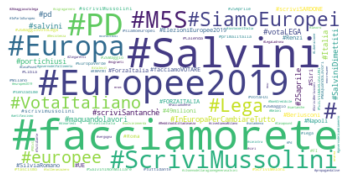

In [ ]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(hashtags_freq)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
users_freq = pattern_freq(comments['text'].values, PATTERNS['users'])        
users_freq.most_common(10)

[('@Utente_Generico', 19119),
 ('@matteosalvinimi', 4321),
 ('@CarloCalenda', 3590),
 ('@GiorgiaMeloni', 1793),
 ('@Ale_Mussolini_', 1702),
 ('@DSantanche', 1349),
 ('@pdnetwork', 1299),
 ('@forza_italia', 1274),
 ('@CaioGCM', 1210),
 ('@civati', 1208)]

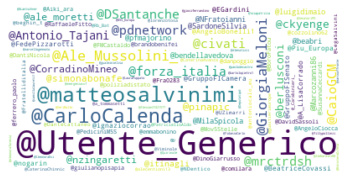

In [ ]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(users_freq)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
urls_freq = pattern_freq(comments['text'].values, PATTERNS['urls'])        
urls_freq.most_common(10)

[('https://incursiomigrantum.blogspot.com/', 23),
 ('www.ilministerodellabellezza.com', 14),
 ('https://t.me/LauraFerrara', 14),
 ('https://www.cesenatoday.it/cronaca/feroce-zuffa-nella-chiesa-ortodossa-devastata-la-navata.html',
  6),
 ('https://www.facebook.com/1221875847970848/posts/1333601550131610/', 5),
 ('https://t.co/TGi4MyPhTv', 4),
 ('http://www.crpv.it/doc/89763/DLFE-2369.pdf', 4),
 ('http://www.treccani.it/export/sites/default/90anni/oggetti/img/1954_Pasta_Barilla.png',
  4),
 ('https://incursiomigrantum.blogspot.com', 4),
 ('https://www.open.online/fact-checking/2019/04/29/news/secondo_la_meloni_il_pd_vuole_coprire_con_delle_tendine_le_croci_e_i_simboli_religiosi_nei_cimiteri-202524/',
  4)]

In [ ]:
emojis_freq = pattern_freq(comments['text'].values, PATTERNS['emojis']) 
emojis_freq.most_common(10)

[('üòÇ', 4303),
 ('‚≠ê', 1873),
 ('ü§£', 1778),
 ('üëè', 1582),
 ('üëç', 1412),
 ('üí™', 933),
 ('üáÆüáπ', 836),
 ('üåü', 775),
 ('üíö', 696),
 ('‚ù§Ô∏è', 599)]

### Removal of redundant spaces

In [ ]:
def remove_spaces(text):
    return ' '.join(text.split())

In [ ]:
text_clean = comments["text"].apply(lambda text: remove_patterns(text, PATTERNS.values()))
text_clean = text_clean.apply(lambda text: remove_spaces(text))
comments["text_clean"] = text_clean

In [ ]:
import random
for i in list(np.random.choice(list(comments.index), 5)):
    print(f'Comment {i}')
    print(comments.loc[i]['text'])
    print(comments.loc[i]['text_clean'], '\n')
    print()

Comment 41848
Edin Derviskadic il governo √® 5 Stelle Lega. Non vedo distinzioni anzi... 

Edin Derviskadic il governo √® Stelle Lega. Non vedo distinzioni anzi... 


Comment 47188
@Utente_Generico @CarloCalenda Ecco perch√© vincono le elezioni: sono votati da chi non sa di cosa si parli. 

Ecco perch√© vincono le elezioni: sono votati da chi non sa di cosa si parli. 


Comment 22715
Ripristini la leva obbligatoria 

Ripristini la leva obbligatoria 


Comment 7356
Vero a me nel nostro comune le hanno aumentate 

Vero a me nel nostro comune le hanno aumentate 


Comment 46292
okay campione 

okay campione 




## Lower casing

In [ ]:
def lower_casing(text):
    return(text.lower())

In [ ]:
comments['text_clean'] = comments['text_clean'].apply(lambda text: lower_casing(text)).apply(lambda text: remove_spaces(text))

### NLP with Spacy

In [ ]:
!pip install --upgrade spacy
!python -m spacy download it_core_news_lg
#!python -m spacy download it_core_news_sm

import it_core_news_lg
nlp = it_core_news_lg.load()

**Stop words collection**

In [ ]:
# Import list of stopwords from it_stop_words.py
import sys
sys.path.append(os.path.join(base_dir, "common_start/text_preprocessing"))
from it_stop_words import get_italian_stop_words
my_it_stop_words = get_italian_stop_words()

In [ ]:
from spacy.lang.it.stop_words import STOP_WORDS as it_spacy_stopwords

import nltk
nltk.download('stopwords')
it_nltk_stopwords = nltk.corpus.stopwords.words('italian')


it_stopwords = set(it_spacy_stopwords) | set(it_nltk_stopwords) | my_it_stop_words

for stopword in it_stopwords:
    nlp_vocab = nlp.vocab[stopword]
    nlp_vocab.is_stop = True

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Text-processing**

In [ ]:
text_nlp = comments["text_clean"].apply(lambda text: nlp(text))
comments['text_nlp'] = text_nlp

In [ ]:
# Run this cell to save the processed text
# comments['text_nlp'].to_pickle(os.path.join(base_dir, 'comments_nlp'))

In [ ]:
# Run this cell to load the processed text
# comments['text_nlp'] = pd.read_pickle(os.path.join(base_dir, 'comments_nlp'))

In [ ]:
print(f"{'Token':<20}\t{'Lemma':<20}\t{'is-stop':<8}\t{'is-punct':<8}")
for token in comments['text_nlp'].loc[0]:
    print(f"{token.text:<20}\t{token.lemma_:<20}\t{token.is_stop:^8}\t{token.is_punct:^8}")

Token               	Lemma               	is-stop 	is-punct
c'                  	c'                  	   1    	   0    
√®                   	essere              	   1    	   0    
poco                	poco                	   1    	   0    
da                  	da                  	   1    	   0    
dire                	diro                	   1    	   0    
questa              	questo              	   1    	   0    
√®                   	essere              	   1    	   0    
gente               	gente               	   0    	   0    
che                 	che                 	   1    	   0    
la                  	la                  	   1    	   0    
guerra              	guerra              	   0    	   0    
c'                  	c'                  	   1    	   0    
√®                   	essere              	   1    	   0    
l                   	l                   	   1    	   0    
ha                  	avere               	   1    	   0    
portata             	portato         

## Removal of Stop-Words

In [ ]:
def remove_stop(tokens):
    return(' '.join([token.lemma_ for token in tokens if not token.is_stop)]))

In [ ]:
text_wo_stop = comments["text_nlp"].apply(lambda tokens: remove_stop(tokens))
comments['text_clean'] = text_wo_stop

## Removal of punctuation

In [ ]:
import string
punct = string.punctuation
# we don't want to remove # simbol:
punct = punct.replace("#", "")
print(f"Punctuation symbols: {punct}")

Punctuation symbols: !"$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [ ]:
def remove_punctuation(text):
    return(''.join([t if not t in string.punctuation else ' ' for t in text]))

In [ ]:
text_wo_stop_punct = comments['text_clean'].apply(lambda text: remove_punctuation(text))
comments['text_clean'] = text_wo_stop_punct

In [ ]:
comments["text_clean"] = comments['text_clean'].apply(lambda text: remove_spaces(text))

In [ ]:
import random
for i in list(np.random.choice(list(comments.index), 20)):
    print(f'Comment {i}')
    print(comments.loc[i]['text'])
    print(comments.loc[i]['text_clean'])
    print()

## Resulting word-cloud

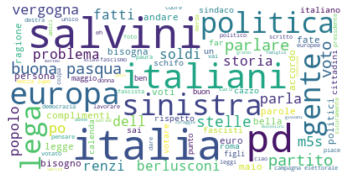

In [ ]:
full_cleaned_text = ' '.join([doc for doc in comments['text_clean']])

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(full_cleaned_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Text Cleaning from function

See text_preprocessing folder

In [ ]:
# Note: text_preprocessing folder has to be updasted. We'll do it after fixing text-preprocessing problems
'''
# Import list of stopwords from it_stop_words.py
import sys
sys.path.append(os.path.join(base_dir, "Semantic_Group/text_preprocessing"))
from text_cleaning import *

cleaned_text = clean_content(comments['text'])
'''

  0% (5 of 78174) |                      | Elapsed Time: 0:00:00 ETA:   0:27:42

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


100% (78174 of 78174) |##################| Elapsed Time: 0:23:06 Time:  0:23:06


In [ ]:
'''
full_cleaned_text = ' '.join(cleaned_text)

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(full_cleaned_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
'''

## Most/Less popular words

In [ ]:
def words_freq(docs):
    words_count = Counter()
    for text in docs:
        for word in text.split():
            words_count[word] += 1
    return words_count

In [ ]:
words_count = words_freq(comments['text_clean'])

In [ ]:
print('Total words\n')
len(words_count.most_common())

47751

In [ ]:
print('Most popular words\n')
words_count.most_common(30)

In [ ]:
less_common = [(w, wc) for (w, wc) in words_count.most_common()[:-31:-1]]
print('Less popular words\n')
for (w, wc) in less_common: print((w, wc), end='\n')

('fdo', 1)
('consigliatissima', 1)
('smettano', 1)
('satanassi', 1)
('mandi', 1)
('celesti', 1)
('ùêàùêïùêëùêûùê¢ùêúùê°', 1)
('ùêÄùê¨ùê©ùêûùê≠ùê≠ùêöùêßùêùùê®ùêèùê´ùê®ùê¶ùêûùê≠ùêûùê®', 1)
('earth', 1)
('ndrine', 1)
('quellivche', 1)
('i‚Äô', 1)
('manno', 1)
('a‚Äô', 1)
('cacciando', 1)
('scappereccio', 1)
('ilegale', 1)
('successi', 1)
('cambiarli', 1)
('utilita', 1)
('musa', 1)
('tedesca', 1)
('spegnermi', 1)
('balzellare', 1)
('comprenderne', 1)
('additandoli', 1)
('linguisticamente', 1)
('tentano', 1)
('licompeza', 1)
('malducati', 1)


**How many words occur 1 time? How many 2 times? ...**

In [ ]:
import seaborn as sns

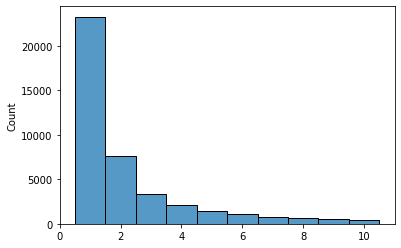

In [ ]:
counts = [wc for (w, wc) in words_count.most_common()]
sns.histplot(counts, bins=[1,2,3,4,5,6,7,8,9,10], discrete=True, binrange=[1,10])